## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering

March 13th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the
references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the
theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Segmentation Notes / Exercises

In [1]:
# Import libraries
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
from matplotlib import colors
from scipy.ndimage import convolve
import skimage

In this section, we shift our attention from image processing techniques were both the input and output of our system
are images. Instead, we now seek to extract features or attributes from our input images. In particular, we will consider
segmentation, which consists of subdividing our image into regions.

First, we will explore point, lines, and edge detection which is a way to segment an image based on sharp or abrupt
transitions in the image's intensity values. Edge detection can be considered an image segmentation technique based on
intensity discontinuities.

**Some background**

Mathematically, we can represent segmentation as a process that partitions an image into $n$ subregions that satisfy the
following properties, where $R$ is the entire spatial region occupied by the image [DIPUM]:

a) $\bigcup\limits_{i=1}^{n} R_{i} = R$.

b) $R-i$ is a connected set for $i = 0, 1, 2, ..., n$.

c) $R_i \cap R_j = \emptyset$ for all valid values of $i$ and $j$, $i \neq j$.

d) $Q(R_i) = TRUE$ for $i = 0, 1, 2, ..., n$.

e) $Q(R_i \cup R_j) = FALSE$ for all adjacent regions $R_i$ and $R_j$.

Where $Q(R_k)$ is a *logical* *predicate* defined over the elements in the set $R_k$. For example, $Q$ can be a compound
predicate such as: $Q(R_i) = TRUE$ is the average intensity of the pixels in region $R_i$ is less than $m_i$ AND if the
standard deviation of the intensity values is greater than $\sigma_i$.

### Point, Line, and Edge Detection

Our main tools for segmenting points, lines, and edges in this section are derivative operators. For an image or digital
function, derivatives are computed as *finite differences*. [DIP] goes into details about deriving appropriate finite
difference equations to compute derivatives, but let's summarize the main findings here.

1) First-order derivatives generally produce thicker edges.

2) Second-order derivatives have a stronger response to fine detail, such as thin lines, isolated points, and noise.

3) Second-order derivatives produce a double-edge response at ramp and step transitions in intensity.

4) The sign of the second derivative can be used to determine whether a transition into an edge is from light to dark
(negative second-derivative) or dark to light (positive second derivative).

**Detection of Isolated Points**

Based on the conclusions summarized above, we can detect isolated points using the second derivative. We use the Laplacian
operator defined as:

\begin{equation}
\nabla^2\boldsymbol{f}(x,y) = \frac{\partial^2 f}{\partial x^2} f(x,y) + \frac{\partial^2 f}{\partial y^2} f(x,y)
\end{equation}

We can compute the Laplacian of an image using the Laplacian kernel shown below.

\begin{equation}
Lk  = \begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}
\end{equation}

We can then say that a point has been detected at location $(x,y)$ if the absolute value of the filter's response at that
location exceeds a specified threshold.

\begin{equation}
g(x,y) =
  \begin{cases}
                                   1 & \text{if}~~|Z(x,y)| \gt T \\
                                   0 & \text{otherwise}
  \end{cases}
\end{equation}

Let's find an isolated point... We will load an image with an artifact visible as a single black pixel in a jet turbine,
and try to isolate it.

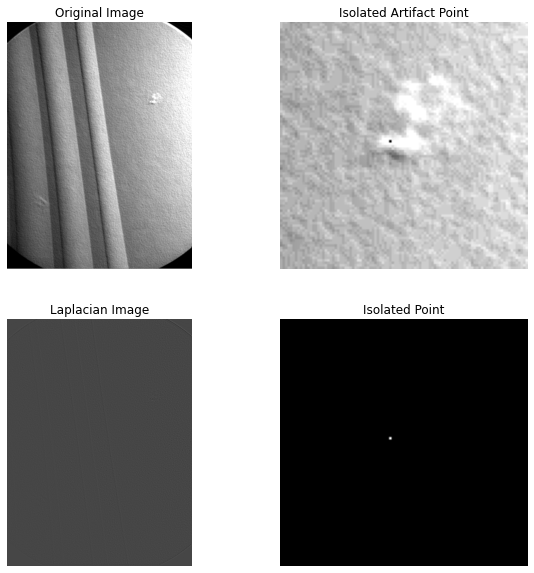

In [2]:
# load image
img_turbine = skimage.img_as_float(io.imread('./images/turbine_blade_black_dot.tif'))
img_turb_artifact = img_turbine[200:300, 400:500]

# define Laplacian kernel
lapl_krnl = (1/8) * np.array([[1, 1, 1],
                      [1, -8, 1],
                      [1, 1, 1]], dtype=np.float)

# compute the Laplacian
img_turb_lapl = convolve(img_turbine, lapl_krnl)

# threshold to isolate point

# compute threshold as 90% of the maximum value
thresh = 0.9 * np.max(np.abs(img_turb_lapl))

# produce threshold image
img_turb_point = np.where(img_turb_lapl > thresh, 1, 0)
img_turb_point = img_turb_point[200:300, 400:500]

# display images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : [img_turbine, img_turb_artifact, img_turb_lapl, img_turb_point],
                'titles' : ['Original Image', 'Isolated Artifact Point', 'Laplacian Image', 'Isolated Point']})

Note in the example above how we were able to isolate a single artifact point from our image. These type of operations
are useful when we know we have isolated points and trying to find artifacts or faults, but the approach is very crude
since the Laplacian of an image is very sucesptible to noise.


**Line Detection**

We can also use the Laplacian operator to detect lines in our images. From the conclusions summarized above, we know that
second derivatives tend to produce thinner lines than first derivatives, but they also produce double-edges. Let's take
a look at an example.

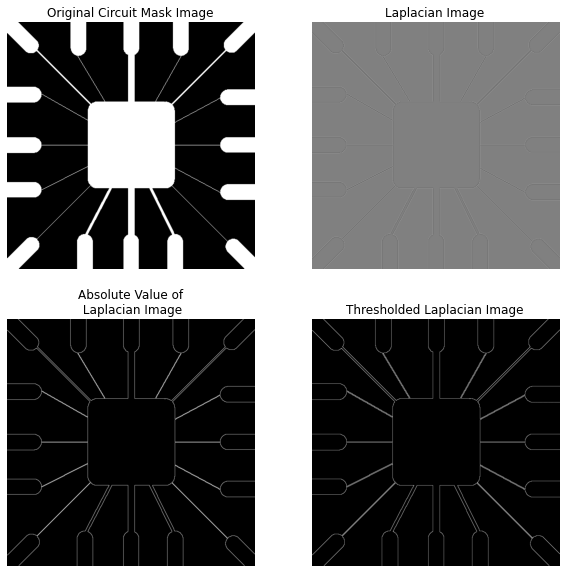

In [3]:
# load circuit mask image
img_ckt = skimage.img_as_float(io.imread('./images/circuitmask.tif'))

# compute the Laplacian of our circuit mask image
img_ckt_lapl = convolve(img_ckt, lapl_krnl)

# take the absolute value of the Laplacian image, for experimentation
img_ckt_lapl_abs = np.abs(img_ckt_lapl)

# threshold the image instead
img_ckt_lapl_thresh = np.where(img_ckt_lapl > 0.0, 1, 0)

# display the images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : [img_ckt, img_ckt_lapl, img_ckt_lapl_abs, img_ckt_lapl_thresh],
                'titles' : ['Original Circuit Mask Image', 'Laplacian Image',
                            'Absolute Value of\n Laplacian Image', 'Thresholded Laplacian Image']})

Let's compute the difference between the absolute value of the Laplacian image and the thresholded binary edge map.


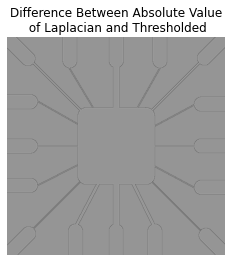

In [4]:
img_ckt_edge_diff = img_ckt_lapl_abs - img_ckt_lapl_thresh
plt.figure()
plt.imshow(img_ckt_edge_diff, cmap='gray')
plt.title("Difference Between Absolute Value\n of Laplacian and Thresholded")
plt.axis('off');

Let's zoom into an area of interest to check what is happening with our image processing operations.

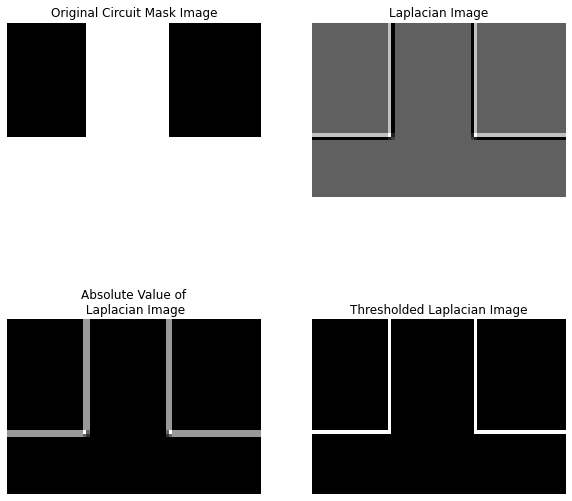

In [5]:
img_ckt_zooms = [img_ckt[280:335, 450:530],
                 img_ckt_lapl[280:335, 450:530],
                 img_ckt_lapl_abs[280:335, 450:530],
                 img_ckt_lapl_thresh[280:335, 450:530]]

# display the images
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : img_ckt_zooms,
                'titles' : ['Original Circuit Mask Image', 'Laplacian Image',
                            'Absolute Value of\n Laplacian Image', 'Thresholded Laplacian Image']})

Note from the zoomed images displayed above that computing the absolute value of our Laplacian image produces a grayscale
image and not a clear delineation between what's an edge and what is not an edge. When the latter is needed, we're better
off thresholding our image as shown in the example above.

**Detecting lines in specified directions**

In the example outlined above, the Laplacian kernel is isotropic. That is, its response is independent of direction.
Sometimes we are interested in finding edges along a particular direction. For example, we can define the following
kernels and their associated directions.

*Horizontal*

\begin{equation}
k_{hor} = \begin{bmatrix}
-1 & -1 & -1\\
2 & 2 & 2\\
-1 & -1 & -1
\end{bmatrix}
\end{equation}

$+45^{\circ}$

\begin{equation}
k_{+45} = \begin{bmatrix}
2 & -1 & -1\\
-1 & 2 & -1\\
-1 & -1 & 2
\end{bmatrix}
\end{equation}


*Vertical*

\begin{equation}
k_{ver} = \begin{bmatrix}
-1 & 2 & -1\\
-1 & 2 & -1\\
-1 & 2 & -1
\end{bmatrix}
\end{equation}

$-45^{\circ}$

\begin{equation}
k_{-45} = \begin{bmatrix}
-1 & -1 & 2\\
-1 & 2 & -1\\
2 & -1 & -1
\end{bmatrix}
\end{equation}

Let's try these kernels out with our circuit mask image...

In [6]:
def directional_laplacian_krnl(dir='isotropic'):
    """
    Function to return a Laplacian kernel given a direction string
    @param dir: string specifying Laplacian kernel's direction
    @return: 3x3 ndarray with Laplacian kernel
    """

    if dir == 'isotropic':
        krnl = np.array([[1, 1, 1],
                        [1, -8, 1],
                        [1, 1, 1]], dtype=np.float)

    if dir == 'horizontal':
        krnl = np.array([[-1, -1, -1],
                        [2, 2, 2],
                        [-1, -1, -1]], dtype=np.float)

    if dir == 'vertical':
        krnl = np.array([[-1, 2, -1],
                        [-1, 2, -1],
                        [-1, 2, -1]], dtype=np.float)

    if dir == 'pos_45':
        krnl = np.array([[2, -1, -1],
                         [-1, 2, -1],
                         [-1, -1, 2]], dtype=np.float)

    if dir == 'neg_45':
        krnl = np.array([[-1, -1, 2],
                         [-1, 2, -1],
                         [2, -1, -1]], dtype=np.float)

    return krnl

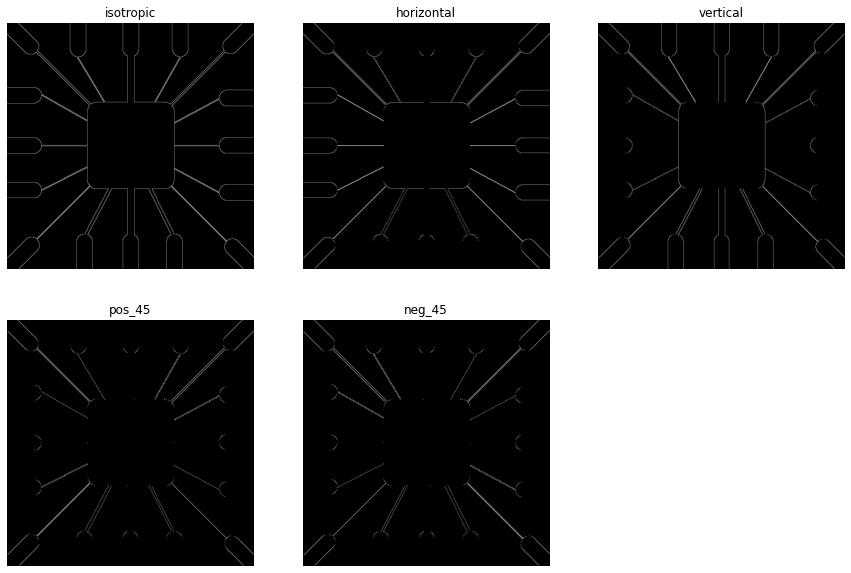

In [7]:
# Detect lines in multiple directions
directions = ['isotropic', 'horizontal', 'vertical', 'pos_45', 'neg_45']

ckt_lines_lst = list()

for dir in directions:

    # compute the Laplacian
    lpl = convolve(img_ckt, directional_laplacian_krnl(dir))

    #threshold
    lpl = np.where(lpl > 0, 1, 0)

    # store
    ckt_lines_lst.append(lpl)

# display results
ec_img_utils.gray_img_comparison_plot({'nrow' : 2,
                'ncol' : 3,
                'figsize' : (15, 10),
                'images' : ckt_lines_lst,
                'titles' : directions})

Note how the horizontal and vertical Laplacian responses vary in the directions of maximum responses. The horizontal
Laplacian edge map contains pronounced horizontal lines in our circuit mask and the opposite is true for our vertical
lines map. Similarly, we see that the positive and negative $45^{\circ}$ line maps have opposite regions of maximum
intensity.

If we repeat the experiment, but this time thresholding with a higher value, we can be more aggressive and separate the
lines along the individual directions more.

**Edge Detection**

As described previously, edge detection is a form of image segmentation based on intensity discontinuities. In edge
detection, objects or regions in the image are differentiated from the background by detecting their boundaries.

The first and second order derivatives of an image are used to detect the intensity discontinuities. We can compute the
first-order derivative with the gradient operator. The gradient of a 2D function $f(x,y)$ is defined as:

\begin{equation}
\nabla[\boldsymbol{f}(x,y)] =
\begin{bmatrix} g_x \\ g_y \end{bmatrix} =
\begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
\end{equation}

The magnitude of the gradient is defined as:

\begin{equation}
|\nabla\boldsymbol{f}(x,y)| = [g_x^2 + g_y^2]^{1/2} \approx |g_x| + |g_y|
\end{equation}

and the direction of maximum rate of change can be found as the arctangent of the vertical to the horizontal gradients.
Note that this is a *four-quadrant* arctangent.

\begin{equation}
\alpha(x,y) = tan^{-1}\frac{g_y}{g_x}
\end{equation}

Second-order derivatives for image processing are usually computed using the *Laplacian* operator. The Laplacian of a 2D
function $f(x,y)$ is defined as:

\begin{equation}
\nabla^2\boldsymbol{f}(x,y) = \frac{\partial^2 f}{\partial x^2} f(x,y) + \frac{\partial^2 f}{\partial y^2} f(x,y)
\end{equation}

As described in [DIPUM], the Laplacian of an image is highly sensitive to noise, and its magnitude is prone to producing
double edges. However, it is still used as a pre-processing step in more advanced edge detection algorithms.

#### Sobel Edge Detector

The Sobel edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below.

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + 2z_2 + z_3) - (z_7 + 2z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + 2z_4 + z_7) - (z_3 + 2z_6 + z_9)
\end{equation}

And the corresponding Sobel kernels are as shown below.

\begin{equation}
Sobel_x = \begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Sobel_y = \begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try this out... First, let's compute the gradient images in the horizontal and vertical directions.

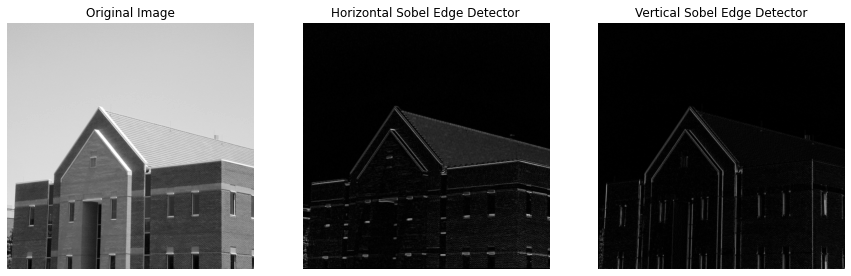

In [8]:
# Load building image
img_building = io.imread('./images/building.tif')

# compute the horizontal gradient image
img_bld_hor_sobel = skimage.filters.sobel_h(img_building)

# compute the vertical gradient image
img_bld_ver_sobel = skimage.filters.sobel_v(img_building)

# compute the absolute value of the gradient images
img_bld_hor_sobel = np.abs(img_bld_hor_sobel)
img_bld_ver_sobel = np.abs(img_bld_ver_sobel)

# display the results
ec_img_utils.gray_img_comparison_plot({
                                    'nrow' : 1,
                                    'ncol' : 3,
                                    'figsize' : (15, 5),
                                    'images' : [img_building, img_bld_hor_sobel, img_bld_ver_sobel],
                                    'titles' : ['Original Image',
                                                'Horizontal Sobel Edge Detector',
                                                'Vertical Sobel Edge Detector']})

As expected, and as seen from our lines example above, the horizontal and vertical edges have been extracted using
appropriate Sobel kernels. Combining these two operations results in a more robust edge detection algorithm.

**Custom Sobel Edge Detector**

In [9]:
def edge_sobel(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Sobel kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.sobel(img, axis=0, mode='reflect')
    grad_y = skimage.filters.sobel(img, axis=1, mode='reflect')

    # compute gradient magnitude
    sobel_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        sobel_edge = sobel_edge > thresh

    return sobel_edge

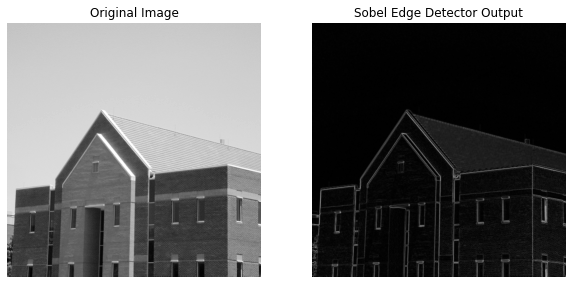

In [10]:
# Test my sobel edge detector

# perform Sobel edge detection
img_build_edge_sob = edge_sobel(img_building)

# display the images
sobel_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_sob],
                'titles' : ['Original Image', 'Sobel Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(sobel_params)

#### Prewitt Edge Detector

The Prewitt edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below:

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_1 + z_2 + z_3) - (z_7 + z_8 + z_9)
\end{equation}

\begin{equation}
g_y = (z_1 + z_4 + z_7) - (z_3 + z_6 + z_9)
\end{equation}

and the corresponding Prewitt kernels are as shown below.

\begin{equation}
Prewitt_x = \begin{bmatrix}
1 & 1 & 1\\
0 & 0 & 0\\
-1 & -1 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Prewitt_y = \begin{bmatrix}
1 & 0 & -1\\
1 & 0 & -1\\
1 & 0 & -1
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try it out...

**Custom Prewitt Edge Detector**

In [11]:
def edge_prewitt(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Prewitt kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.prewitt(img, axis=0, mode='reflect')
    grad_y = skimage.filters.prewitt(img, axis=1, mode='reflect')

    # compute gradient magnitude
    prewitt_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        prewitt_edge = prewitt_edge > thresh

    return prewitt_edge

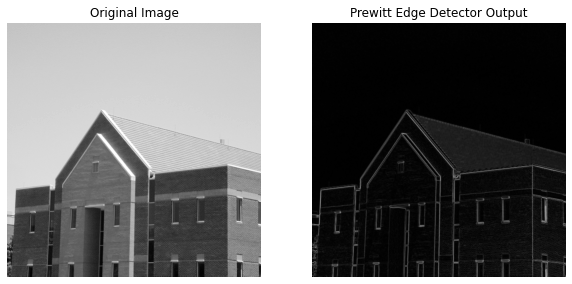

In [12]:
# Test my Prewitt edge detector

# perform Prewitt edge detection
img_build_edge_prewitt = edge_prewitt(img_building)

# display the images
prewitt_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_prewitt],
                'titles' : ['Original Image', 'Prewitt Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(prewitt_params)

Let's compare the Sobel and Prewitt Edge Detectors. Let's compute the absolute difference between the two edge maps

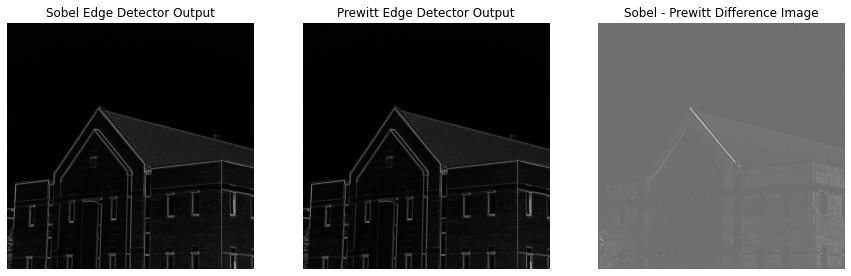

In [13]:
# compute the difference between the Sobel and Prewitt edge detectors
sobel_prewitt_diff = ec_img_utils.normalize_zero_one(img_build_edge_sob - img_build_edge_prewitt)

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_build_edge_sob, img_build_edge_prewitt, sobel_prewitt_diff],
                'titles' : ['Sobel Edge Detector Output', 'Prewitt Edge Detector Output',
                            'Sobel - Prewitt Difference Image']})

Note that even though it is a bit difficult to discern the difference between the Sobel and Prewitt edge maps, they are
indeed different. My approach to visualize the difference consists in computing the difference between the two edge maps
and normalizing the result between [0, 1] to display the results. Note how the diagonal at the top of the building is
very prominent in the difference image.

Also, note how we the outer walls of the building are clearly visible in the difference image. This indicates that our
edge map is not just outlining the building boundary, but it also contains local details that we may not be interested
in. We'll see more robust techniques later. One common way to mitigate some of the local details like the concrete wall
is to smooth the image prior to performing edge detection. This results in a **less noisy** image prior to edge detection.

**Smoothing prior to edge detection**

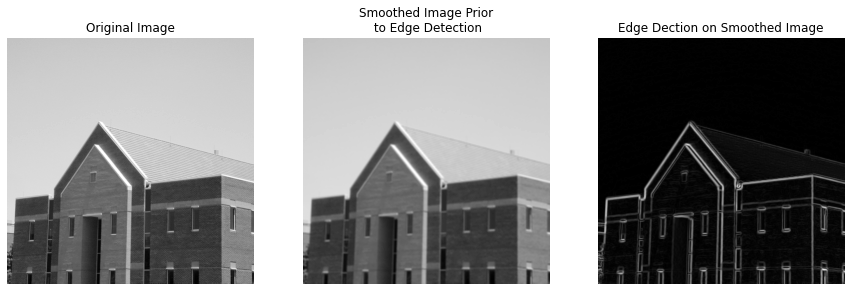

In [14]:
# smooth building image first
img_bld_smooth = convolve(img_building, (1/25) * np.ones((5,5)))

# perform edge detection now
img_bldg_smooth_edge = np.abs(edge_sobel(img_bld_smooth))

# display the results
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_building, img_bld_smooth, img_bldg_smooth_edge],
                'titles' : ['Original Image', 'Smoothed Image Prior\n to Edge Detection',
                            'Edge Dection on Smoothed Image']})

Note from the example above that our building edges are more pronounced and we maintain less detail in the concrete walls
compared to the results we obtained without smoothing the image first. Usually, smoothing and thresholding are combined
to achieve a particular level of performance needed.

#### Roberts Edge Detector

The Roberts edge detector approximates the first-order derivatives as discrete differences in a small pixel neighborhood
as shown below. The Roberts edge detector is one of the oldest and crudest edge detectors and not too commonly used [DIPUM].

\begin{equation}
Neighborhood = \begin{bmatrix}
z_1 & z_2 & z_3\\
z_4 & z_5 & z_6\\
z_7 & z_8 & z_9
\end{bmatrix}
\end{equation}

\begin{equation}
g_x = (z_5 - z_9)
\end{equation}

\begin{equation}
g_y = (z_6 - z_8)
\end{equation}

and the corresponding Roberts kernels are as shown below.

\begin{equation}
Roberts_x = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\end{equation}

We can compute the gradient as the square root of the sum in quadrature of the x- and y-gradients as outlined above.

Let's try it out...

**Custom Roberts Edge Detector**

In [15]:
def edge_roberts(img, thresh=0):
    """
    Function to perform edge detection on an input grayscale image using a Roberts kernel
    @param thresh: float with threshold parameter
    @param img: ndarray-like grayscale image or channel. This function assumes a single channel image. If RGB is needed,
                individual channels may be computed individually.
    @return:    ndarray-like edge map. Same dimensions as the input image
    """

    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Compute gradients in x and y direction using a Sobel filter
    grad_x = skimage.filters.roberts_pos_diag(img)
    grad_y = skimage.filters.roberts_neg_diag(img)

    # compute gradient magnitude
    roberts_edge = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

    if thresh != 0:
        roberts_edge = roberts_edge > thresh

    return roberts_edge

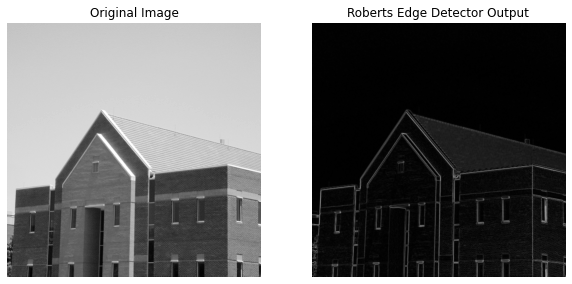

In [16]:
# Test my Roberts edge detector

# perform Prewitt edge detection
img_build_edge_roberts = edge_prewitt(img_building)

# display the images
roberts_params = {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_build_edge_roberts],
                'titles' : ['Original Image', 'Roberts Edge Detector Output']}

ec_img_utils.gray_img_comparison_plot(roberts_params)

Compute the difference images between the Sobel-Roberts and Prewitt-Roberts pairs

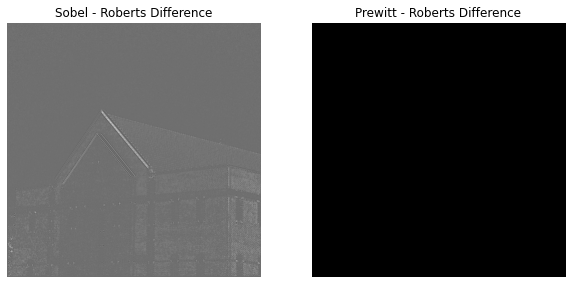

In [17]:
# compute differences
sobel_roberts_diff = img_build_edge_sob - img_build_edge_roberts
prewitt_roberts_diff = img_build_edge_prewitt - img_build_edge_roberts

# display the difference images
ec_img_utils.gray_img_comparison_plot(
                {'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [sobel_roberts_diff, prewitt_roberts_diff],
                'titles' : ['Sobel - Roberts Difference', 'Prewitt - Roberts Difference']})

Interestingly, in this example, the Prewitt edge detector and the Roberts edge detector product the same results. Let's
use a different image to verify that the three edge detectors produce different results.

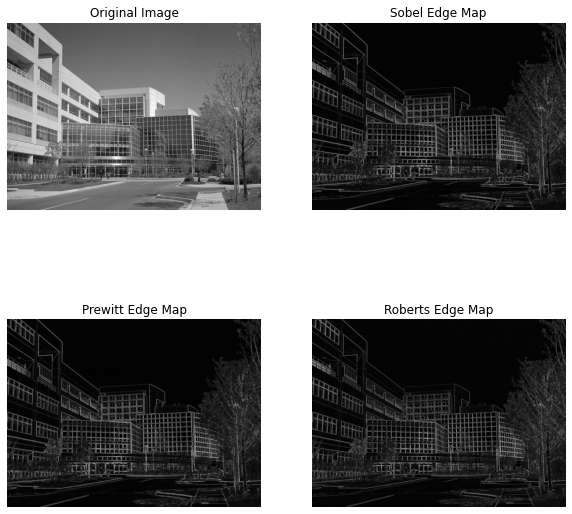

In [18]:
# load nationla archives image
img_nat_arch = io.imread('./images/national-archives-bld.tif')

# compute edge maps
nat_arch_edge_maps = []

nat_arch_edge_maps.append(img_nat_arch)
nat_arch_edge_maps.append(edge_sobel(img_nat_arch))
nat_arch_edge_maps.append(edge_prewitt(img_nat_arch))
nat_arch_edge_maps.append(edge_roberts(img_nat_arch))

# display the edge maps
ec_img_utils.gray_img_comparison_plot(
                {'nrow' : 2,
                'ncol' : 2,
                'figsize' : (10, 10),
                'images' : nat_arch_edge_maps,
                'titles' : ['Original Image', 'Sobel Edge Map',
                            'Prewitt Edge Map', 'Roberts Edge Map']})

Compute the pairwise differences

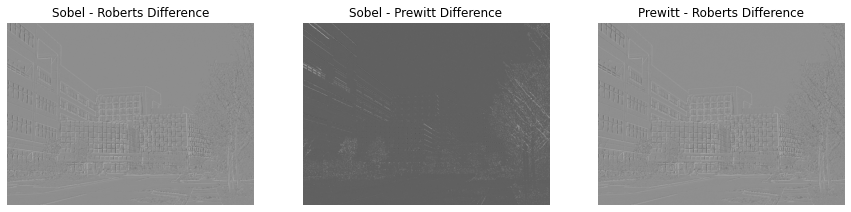

In [19]:
nat_arch_sobel_roberts_diff = nat_arch_edge_maps[1] - nat_arch_edge_maps[3]
nat_arch_sobel_prewitt_diff = nat_arch_edge_maps[1] - nat_arch_edge_maps[2]
nat_arch_prewitt_roberts_diff = nat_arch_edge_maps[2] - nat_arch_edge_maps[3]

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [nat_arch_sobel_roberts_diff, nat_arch_sobel_prewitt_diff, nat_arch_prewitt_roberts_diff],
                'titles' : ['Sobel - Roberts Difference',
                            'Sobel - Prewitt Difference',
                            'Prewitt - Roberts Difference']})

In the National Archives image example shown above, we confirm that the three edge detectors produce different results.

Try out the Roberts kernels instead

\begin{equation}
Roberts_x = \begin{bmatrix}
-1 & 1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
-1 \\
1
\end{bmatrix}
\end{equation}


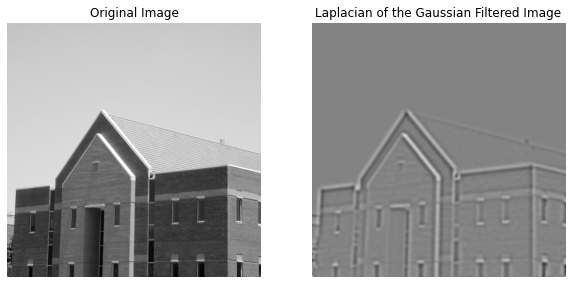

In [20]:
# trying to code up the Laplacion of Gaussian Edge Detector

# Step 1) Smooth the image with a Gaussian filter
sigma = 4

def round_up_to_odd(n):
    return ((np.ceil(n) // 2) * 2 + 1).astype(int)

# determine the size of the Gaussian kernel
n_gaussian = round_up_to_odd(6 * sigma)

# filter the image
img_bld_gaussian = skimage.filters.gaussian(img_building, sigma=sigma, truncate=4.0)

# Step 2) Compute the Laplacian of the smoothed image
img_building_gauss_lpl = skimage.filters.laplace(img_bld_gaussian)

# display the results so far before we attempt to find the zero crossings
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, img_building_gauss_lpl],
                'titles' : ['Original Image',
                            'Laplacian of the Gaussian Filtered Image']})

Step 3 is to find the zero crossings. As outlined in DIP 4th ed., to find zero crossings, we look at a 3x3 neighborhood
around each pixel of our Laplacian of Gaussian image. A zero crossing at pixel $p$ implies that the signs of at least two
of its opposing neighboring pixels must differ. There are four case to test: left/right, up/down, and the two diagonals.
As we will see below, we also introduce a threshold to mitigate the effects of image noise, and thereby, false edges or
unwanted local detail in our edge map.

In [21]:
# Step 3) Find the zero crossings

# first compute the sign of the Laplacian image at each pixel location
lap_sign = np.sign(img_building_gauss_lpl)

# Define Roberts kernels to compute the pairwise difference between pixels in each direction
roberts_hor = np.array([-1, 1]).reshape(1,-1)
roberts_ver = np.array([-1, 1]).reshape(-1,1)

sign_diff_hor = convolve(lap_sign, roberts_hor, mode='constant')
sign_diff_hor = np.logical_or(sign_diff_hor < 0, sign_diff_hor > 0)

sign_diff_ver = convolve(lap_sign, roberts_ver, mode='constant')
sign_diff_ver = np.logical_or(sign_diff_ver < 0, sign_diff_ver > 0)

zero_crss_hor_ver = np.logical_or(sign_diff_ver, sign_diff_hor)

Show the results so far with 4-neighborhood check only and no thresholding

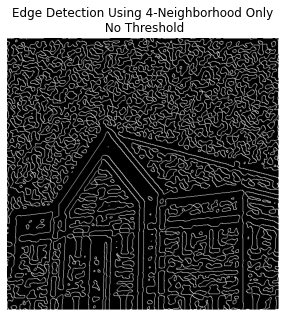

In [22]:
# display
plt.figure(figsize=(5,5))
plt.imshow(zero_crss_hor_ver, cmap='gray')
plt.title("Edge Detection Using 4-Neighborhood Only\n No Threshold")
plt.axis('off');



Next, we threshold our absolute differences to eliminate edges in areas of constant intensity (caused by image noise).
In the example below, the threshold is computed as 2% of the maximum Laplacian pixel value.

In [23]:
# compute threshold
threshold = 0.02 * np.max(img_building_gauss_lpl)

# threshold Laplacian images along rows and columns
rows_abs = convolve(img_building_gauss_lpl, roberts_hor, mode='constant') > threshold
cols_abs = convolve(img_building_gauss_lpl, roberts_ver, mode='constant') > threshold

# compute absolute differences
abs_thres_rows = np.logical_and(rows_abs, sign_diff_hor)
abs_thres_cols = np.logical_and(cols_abs, sign_diff_ver)

Now, let's take a look at our horizontal and vertical results individually and examine whether we were able to supress
the noise

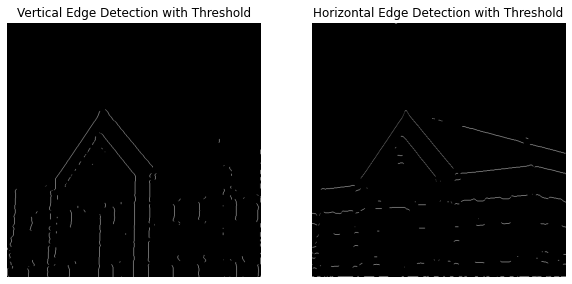

In [24]:
ec_img_utils.gray_img_comparison_plot({'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [abs_thres_rows, abs_thres_cols],
                'titles' : ['Vertical Edge Detection with Threshold',
                            'Horizontal Edge Detection with Threshold']})

Combine the 4-neighborhood edge maps into a single edge map

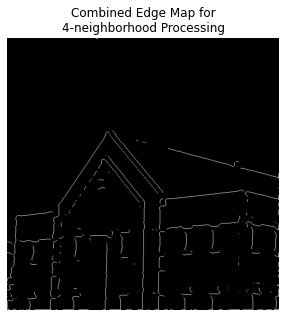

In [25]:
edge_4_neigh = np.logical_or(abs_thres_cols, abs_thres_rows)

# display the results
plt.figure(figsize=(5, 5))
plt.imshow(edge_4_neigh, cmap='gray')
plt.title("Combined Edge Map for\n4-neighborhood Processing")
plt.axis('off');

Next, we find the zero crossings along the diagonals

We can accomplish this by convolving our sign matrix with the following Roberts kernels.

\begin{equation}
Roberts_x = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
\end{equation}

\begin{equation}
Roberts_y = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
\end{equation}

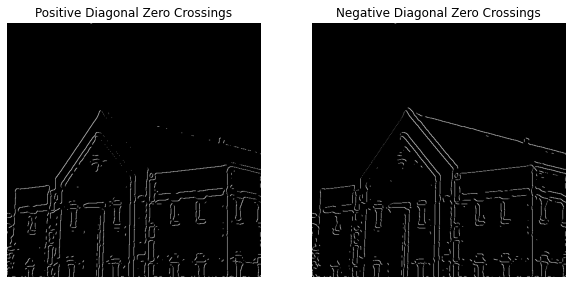

In [26]:
# POSITIVE DIAGONAL
zero_cr_pos_diag = skimage.filters.roberts_pos_diag(lap_sign)

# find the zero crossing pixels
zero_cr_pos_diag = np.logical_or(zero_cr_pos_diag > 0,zero_cr_pos_diag < 0)

# compute the absolute diagonal difference
pos_diag_abs_diff = np.abs(skimage.filters.roberts_pos_diag(img_building_gauss_lpl)) > threshold

# compute the positive diagonal zero crossings for the positive diagonal
pos_diag = np.logical_and(zero_cr_pos_diag, pos_diag_abs_diff)

# NEGATIVE DIAGONAL

# negative diagonal direction
zero_cr_neg_diag = skimage.filters.roberts_neg_diag(lap_sign)

# find the zero crossing pixels
zero_cr_neg_diag = np.logical_or(zero_cr_neg_diag > 0,zero_cr_neg_diag < 0)

# compute the absolute diagonal difference
neg_diag_abs_diff = np.abs(skimage.filters.roberts_neg_diag(img_building_gauss_lpl)) > threshold

# compute the positive diagonal zero crossings for the negative diagonal
neg_diag = np.logical_and(zero_cr_neg_diag, neg_diag_abs_diff)

ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [pos_diag, neg_diag],
                'titles' : ['Positive Diagonal Zero Crossings',
                            'Negative Diagonal Zero Crossings']})

Display the diagonal zero crossings so far

In [27]:
neg_diag = np.logical_and(zero_cr_neg_diag, neg_diag_abs_diff)

Combine all zero crossings into a single edge map

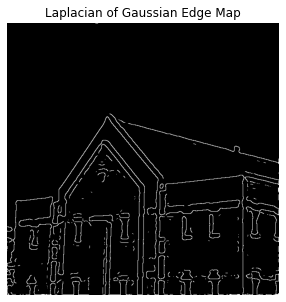

In [28]:
LoG_edge_map = np.logical_or(np.logical_or(pos_diag, neg_diag), edge_4_neigh)

# display the results
plt.figure(figsize=(5, 5))
plt.imshow(LoG_edge_map, cmap='gray')
plt.title("Laplacian of Gaussian Edge Map")
plt.axis('off');

Wrap the Laplacian of Gaussian algorithm into a function

In [29]:
def my_laplacian_of_gaussian(img, sigma, thresh_pct):
    """
    Function to implement the Laplacian of Guassian Edge Detection Algorithm or Marr-Hildreth algorithm [DIP]
    @param img: ndarray like image, single channel
    @param sigma: Gaussian smoothing filter standard deviation
    @param thresh_pct: float with percent of max Laplacian of Gaussian pixel values to threshold
                        --> thresh_pct * max(Laplacian of Gaussian Image)
    @return: Laplacian of Gaussian Edge Map
    """
    # convert image to float, just in case
    img = skimage.img_as_float(img)

    # Step 1) Filter the image with the Gaussian kernel
    img_gaussian = skimage.filters.gaussian(img, sigma=sigma)

    # Step 2) Compute the Laplacian of the smoothed image
    img_gauss_lpl = skimage.filters.laplace(img_gaussian)

    # Step 3) Find the zero crossings

    # first compute the sign of the Laplacian image at each pixel location
    lapl_sign = np.sign(img_gauss_lpl)

    # pad the laplacian sign array on both ends
    # Define Roberts kernels to compute the pairwise difference between pixels in each direction
    roberts_hor_krnl = np.array([-1, 1]).reshape(1,-1)
    roberts_ver_krnl = np.array([-1, 1]).reshape(-1,1)

    diff_hor_sign = convolve(lapl_sign, roberts_hor_krnl, mode='constant')
    diff_hor_sign = np.logical_or(diff_hor_sign < 0, diff_hor_sign > 0)

    diff_ver_sign = convolve(lapl_sign, roberts_ver_krnl, mode='constant')
    diff_ver_sign = np.logical_or(diff_ver_sign < 0, diff_ver_sign > 0)

    #zero_crss_4_neigh_sign = np.logical_or(diff_ver_sign, diff_hor_sign)

    # THRESHOLD
    # compute threshold
    t = thresh_pct * np.max(img_gauss_lpl)

    # compute absolute differences
    hor_abs = convolve(img_gauss_lpl, roberts_hor_krnl, mode='constant') > t
    ver_abs = convolve(img_gauss_lpl, roberts_ver_krnl, mode='constant') > t

    # find zero crossings for 4-neighborhood
    abs_diff_hor = np.logical_and(hor_abs, diff_hor_sign)
    abs_diff_ver = np.logical_and(ver_abs, diff_ver_sign)

    # Combine the 4-neighborhood zero crossings from above and absolute differences
    zero_crss_4_neigh = np.logical_or(abs_diff_hor, abs_diff_ver)


    # POSITIVE DIAGONAL
    zero_cr_pos_dia = skimage.filters.roberts_pos_diag(lapl_sign)

    # find the zero crossing pixels
    zero_cr_pos_dia = np.logical_or(zero_cr_pos_dia > 0,zero_cr_pos_dia < 0)

    # compute the absolute diagonal difference
    pos_dia_abs_diff = np.abs(skimage.filters.roberts_pos_diag(img_gauss_lpl)) > t

    # compute the positive diagonal zero crossings for the positive diagonal
    pos_dia = np.logical_and(zero_cr_pos_dia, pos_dia_abs_diff)

    # NEGATIVE DIAGONAL

    # negative diagonal direction
    zero_cr_neg_dia = skimage.filters.roberts_neg_diag(lapl_sign)

    # find the zero crossing pixels
    zero_cr_neg_dia = np.logical_or(zero_cr_neg_dia > 0,zero_cr_neg_dia < 0)

    # compute the absolute diagonal difference
    neg_dia_abs_diff = np.abs(skimage.filters.roberts_neg_diag(img_gauss_lpl)) > t

    # compute the positive diagonal zero crossings for the negative diagonal
    neg_dia = np.logical_and(zero_cr_neg_dia, neg_dia_abs_diff)

    log_edge_map = np.logical_or(np.logical_or(pos_dia, neg_dia), zero_crss_4_neigh)

    return log_edge_map

Test my Laplacian of Gaussian Function

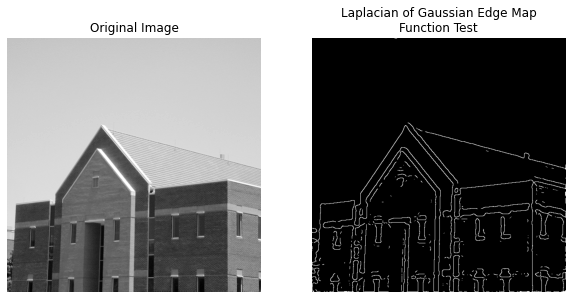

In [30]:
test_log_bld = my_laplacian_of_gaussian(img_building, 4, 0.02)
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_building, test_log_bld],
                'titles' : ['Original Image',
                            'Laplacian of Gaussian Edge Map\nFunction Test']})

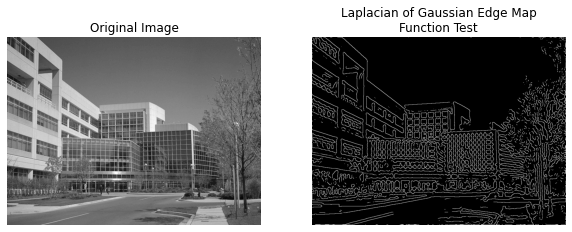

In [31]:
# Test 2
test_log_nat_arch = my_laplacian_of_gaussian(img_nat_arch, 4, 0.02)

ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 2,
                'figsize' : (10, 5),
                'images' : [img_nat_arch, test_log_nat_arch],
                'titles' : ['Original Image',
                            'Laplacian of Gaussian Edge Map\nFunction Test']})

Canny Edge Detection Algorithm

Use skimage's built-in Canny routine

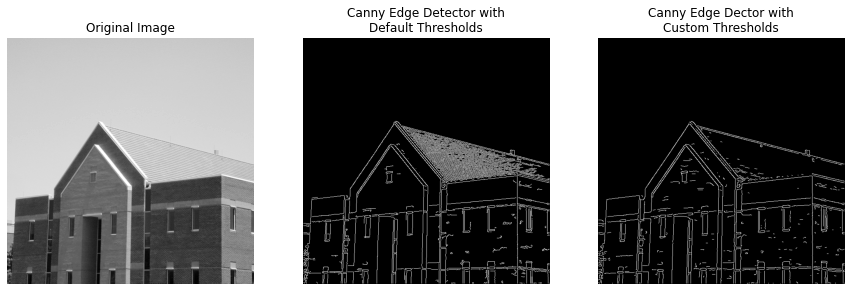

In [32]:
# apply the Canny edge detector without any predefined thesholds. Skimage defaults to 10% of dtype's max for the low
# threshold and 20% of dtype's max for the high threshold

img_bld_canny_dfault = skimage.feature.canny(img_building)

# now provide thresholds myself
img_bld_canny_2 = skimage.feature.canny(skimage.img_as_float(img_building),
                                        sigma=1.5,
                                        low_threshold=0.08,
                                        high_threshold=0.10)

# display the results
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_building, img_bld_canny_dfault, img_bld_canny_2],
                'titles' : ['Original Image',
                            'Canny Edge Detector with\nDefault Thresholds',
                            'Canny Edge Dector with\nCustom Thresholds']})

Add comments

**Comparing the edge maps so far**

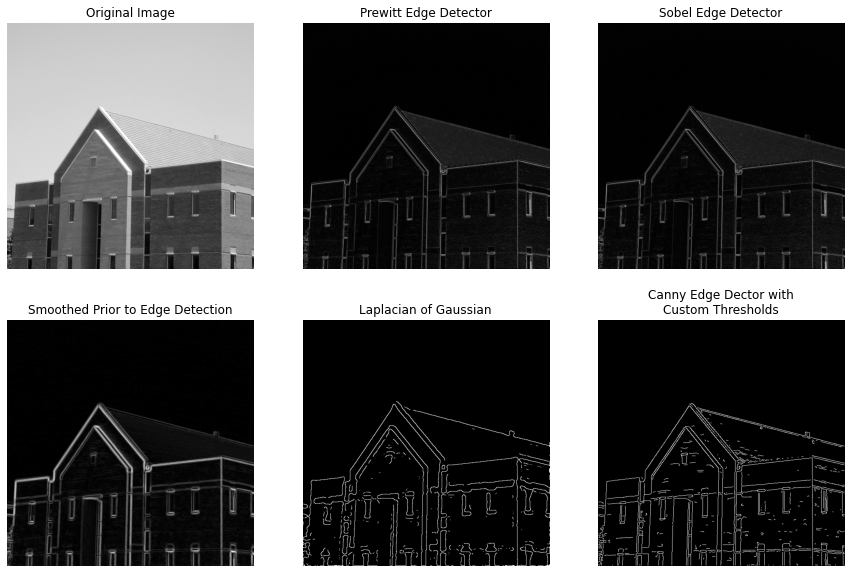

In [33]:
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 2,
                'ncol' : 3,
                'figsize' : (15, 10),
                'images' : [img_building,
                            img_build_edge_prewitt,
                            img_build_edge_sob,
                            img_bldg_smooth_edge,
                            test_log_bld,
                            img_bld_canny_2],
                'titles' : ['Original Image',
                            'Prewitt Edge Detector',
                            'Sobel Edge Detector',
                            'Smoothed Prior to Edge Detection',
                            'Laplacian of Gaussian',
                            'Canny Edge Dector with\nCustom Thresholds']})

### Thresholding

Thresholding is a simple way to segment an image and separate foreground from background, for example. We have seen
examples of these operations already when thresholding our edge maps above.

#### The Basics of Intensity Thresholding and Global Thresholding

One obvious way to extract foreground pixels or objects from the background is by thresholding each pixel in an image
$f(x,y)$ by $T$. The segmented image is given by:

\begin{equation}
g(x,y) =
  \begin{cases}
                                   1 & \text{if}~~f(x,y) \gt T \\
                                   0 & \text{otherwise}
  \end{cases}
\end{equation}

When $T$ is a constant applicable to all pixels in the image $f(x,y)$, our approach is called **global thresholding**.
When the value of $T$ changes over over an image, we use the term **variable thresholding**. Moreover, if the threshold
changes as a function of the spatial coordinates $(x,y)$, the thresholding algorithm is sometimes called **dynamic** or
**adaptive** thresholding.

Following a similar train of thought, **multiple thresholding** classifies a point $(x,y)$ in an image as belonging to
the background if $f(x,y) \leq T_1$, to one object class if $T_1 < f(x,y) \leq T_2$, and to the other object class if
$f(x,y) > T_2$. The segmented image is given by:

\begin{equation}
g(x,y) =
  \begin{cases}
                                   a &  f(x,y) > T_2 \\
                                   b &  T_1 < f(x,y) \leq T_2 \\
                                   c &  f(x,y) \leq T_1
  \end{cases}
\end{equation}

where $a$, $b$, and $c$ are any distinct intensity values. Segmentation problems requiring more than two thresholds are
difficult and other techniques exist to tackle these problems as we will see later.

The thresholding techniques described above, are a form of histogram processing. That is, what we're really doing is
segregating intensity values based on their relative distributions. Thus, these techniques are only useful for instances
where the intensity values we are segmenting on are easily separable. Let's take a look at the impact of noise in our
thresholding endeavor.

**The Role of Noise in Image Thresholding**

In the example below, we will look at a noiseless image and its pertinent histogram. We will then compare the noiseless
histogram with histograms extracted from noisy versions of the image.

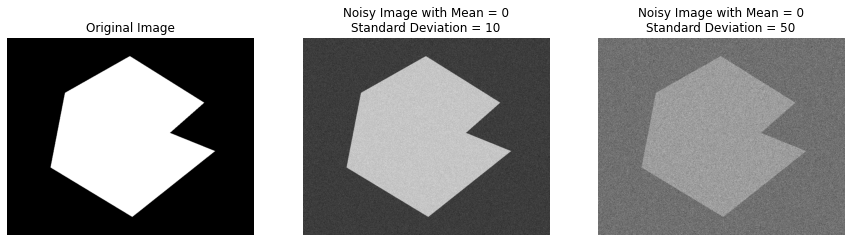

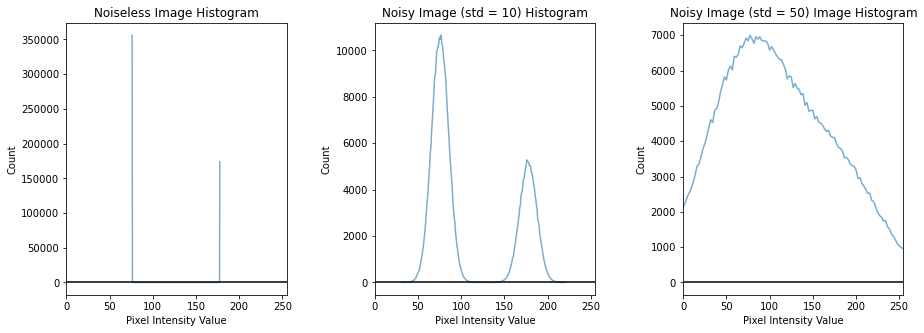

In [34]:
# load septagon image
img_septagon = io.imread('./images/septagon.tif')

# compute histogram
#hist_sep_orig, bins = skimage.exposure.histogram(img_septagon, nbins=256)
hist_sep_orig, bins = np.histogram(img_septagon, bins=256)

# corrupt the septagon image with AWGN, stad dev 10 (from range [0, 255])
img_septagon_noise_10 = img_septagon + np.random.normal(loc=0.0, scale=10, size=img_septagon.shape)

# compute histogram
hist_sep_noise_10, bins_noise_10 = np.histogram(img_septagon_noise_10, bins=256)

# corrupt the septagon image with AWGN, stad dev 150 (from range [0, 255])
img_septagon_noise_50 = img_septagon + np.random.normal(loc=0.0, scale=50, size=img_septagon.shape)

# compute histogram
hist_sep_noise_50, bins_noise_50 = np.histogram(img_septagon_noise_50, bins=256)

# display the images
ec_img_utils.gray_img_comparison_plot({
                'nrow' : 1,
                'ncol' : 3,
                'figsize' : (15, 5),
                'images' : [img_septagon, img_septagon_noise_10, img_septagon_noise_50],
                'titles' : ['Original Image', 'Noisy Image with Mean = 0\nStandard Deviation = 10',
                            'Noisy Image with Mean = 0\nStandard Deviation = 50']})

fig_hist_sep, ax_hist_sep = plt.subplots(1, 3, figsize=(15, 5))
ax_hist_sep = ax_hist_sep.ravel()

ax_hist_sep[0].plot(bins[:-1], hist_sep_orig, alpha=0.6)
ax_hist_sep[0].set_title("Noiseless Image Histogram")
ax_hist_sep[0].set_xlabel("Pixel Intensity Value")
ax_hist_sep[0].set_ylabel("Count")
ax_hist_sep[0].set_xlim([0, 255])
ax_hist_sep[0].axhline(y=0, color='k')

ax_hist_sep[1].plot(bins_noise_10[:-1], hist_sep_noise_10, alpha=0.6)
ax_hist_sep[1].set_title("Noisy Image (std = 10) Histogram")
ax_hist_sep[1].set_xlabel("Pixel Intensity Value")
ax_hist_sep[1].set_ylabel("Count")
ax_hist_sep[1].set_xlim([0, 255])
ax_hist_sep[1].axhline(y=0, color='k')

ax_hist_sep[2].plot(bins_noise_50[:-1], hist_sep_noise_50, alpha=0.6)
ax_hist_sep[2].set_title("Noisy Image (std = 50) Image Histogram")
ax_hist_sep[2].set_xlabel("Pixel Intensity Value")
ax_hist_sep[2].set_ylabel("Count")
ax_hist_sep[2].set_xlim([0, 255])
ax_hist_sep[2].axhline(y=0, color='k')

fig_hist_sep.subplots_adjust(wspace=0.4)

Note from the histogram plots shown above that we can easily separate the background from the foreground pixels for the
original image and even for the noisy image with standard deviation of 10 intensity levels. However, for the image
corrupted by Gaussian noise with a standard deviation of 50 intensity levels, there is no clear way to segment based on
an intensity threshold approach.

#### Basic Global Thresholding

As discussed above, when the intensity distributions of objects and background are sufficiently distinct, it is possible
to use a single (global) threshold for the entire image.

Global thresholding algorithm as outlined in [DIP, 4th ed]

1. Select an initial estimate for the global threshold, $T$.

2. Segment the image using $T$ in the global threshold equation described above. This will produce two groups of pixels:
$G_1$ with intensity values $> T$; and $G_2$ with intensity values $\leq T$.

3. Compute the average (mean) intensity values $m_1$ and $m_2$ for the pixels in $G_1$ and $G_2$, respectively.

4. Compute a new threshold value midway between $m_1$ and $m_2$:

$T = \frac{1}{2}(m_1 + m_2)$

5. Repeat Steps 2 through 4 until the difference between values of $T$ in successive iterations is smaller than a
predefined value, $\Delta T$.

Let's code this up...

In [35]:
def global_threshold_algo(img, T='mean', tol=0.5):
    # convert image to float
    #img = skimage.img_as_float(img)

    if T == 'mean':
        # initialize threshold to mean intensity
        T = np.mean(img)
    else:
        T = T

    num_iter = 0
    delta_flag = False

    while not delta_flag:
        num_iter += 1

        #T_old = T_new

        # Step 2) Segment the image using T. This will produce two groups of pixels: G_1 with intensity values > T; and G_2
        # with intensity values <= T.
        group_1_idx = img > T
        group_2_idx = img <= T

        # Step 3) Compute the average (mean) intensity values m_1 and m_2 for the pixels in G_1 and G_2, respectively.
        mean_grp_1 = np.mean(img[group_1_idx])
        mean_grp_2 = np.mean(img[group_2_idx])

        # Step 4) Compute a new threshold value midway between m_1 and m_2:
        T_new = 0.5 * (mean_grp_1 + mean_grp_2)

        # Repeat Steps 2 through 4 until the difference between values of T in successive iterations is smaller than a
        # predefined value, delta(T).
        delta_flag = np.abs(T_new - T) < tol

        T = T_new

    return T_new, num_iter

In [36]:
# load fingerprint image
img_fingerprint = io.imread('./images/fingerprint.tif')

# run global thresholding algorithm
fingerprnt_T, fingerprnt_num_iter = global_threshold_algo(img_fingerprint)

print("Global threshold found: %0.3f in %d iterations" %(fingerprnt_T, fingerprnt_num_iter))

# threshold the image
img_fingerprint_thresh = np.where(img_fingerprint > fingerprnt_T, 1, 0)

Global threshold found: 125.386 in 2 iterations


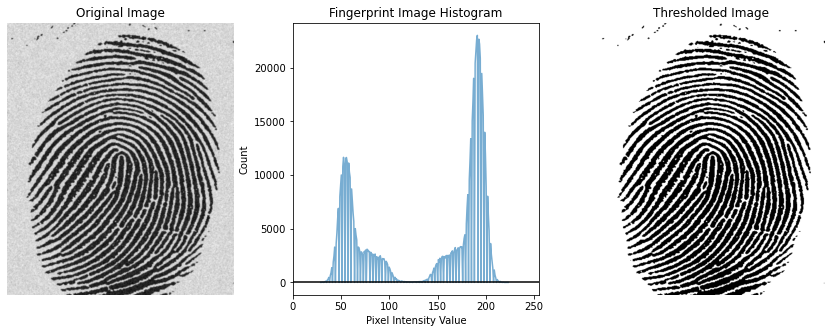

In [37]:
# display results
fig_finergprint, ax_fingerprint = plt.subplots(1, 3, figsize=(15, 5))
ax_fingerprint = ax_fingerprint.ravel()

ax_fingerprint[0].imshow(img_fingerprint, cmap='gray')
ax_fingerprint[0].set_title("Original Image")
ax_fingerprint[0].axis('off')

ax_fingerprint[2].imshow(img_fingerprint_thresh, cmap='gray')
ax_fingerprint[2].set_title("Thresholded Image")
ax_fingerprint[2].axis('off')

# compute the histogram
fingerprint_hist, fingerprint_bins = np.histogram(img_fingerprint, bins=256)
ax_fingerprint[1].plot(fingerprint_bins[:-1], fingerprint_hist, alpha=0.6)
ax_fingerprint[1].set_title("Fingerprint Image Histogram")
ax_fingerprint[1].set_xlabel("Pixel Intensity Value")
ax_fingerprint[1].set_ylabel("Count")
ax_fingerprint[1].set_xlim([0, 255])
ax_fingerprint[1].axhline(y=0, color='k');

Note from the histogram plotted above that we have a bimodal intensity distribution. This is the perfect example to
apply global thresholding. In this case, our algorithm converged in 2 iterations and we were able to segment the
fingerprint foreground objects from the background successfully.

#### Optimum Global Thresholding using Otsu's Method

1. Compute the normalized histogram of the input image. Denote the components of the histogram by
$p_i, i = 0, 1, 2, ..., L-1$.

2. Compute the cumulative sums, $P_1(k)$, for $k = 0, 1, 2, ..., L-1$ using equation:

$P_1(k) = \displaystyle \sum_{i = 0}^{k}p_i$

3. Compute the cumulative means, $m(k)$, for $k = 0, 1, 2, ..., L-1$ using equation:

$m(k) = \displaystyle \sum_{i = 0}^{k}ip_i$

4. Compute the global mean, $m_G$, using equation:

$m_G = \displaystyle \sum_{i = 0}^{L - 1}ip_i$

5. Compute the between-class variance term, $\sigma_{B}^2(k)$, for $k = 0, 1, 2, ..., L-1$ using equation:

$\sigma_{B}^2(k) = \frac{\displaystyle [m_G \times P_1(k) - m(k)]^2}{\displaystyle  P_1(k)[1 - P_1(k)]}$

6. Obtain the Otsu threshold, $k^*$, as the value of $k$ for which $\sigma_{B}^2(k)$ is maximum. If the maximum is not
unique, obtain $k^*$ by averaging the values of $k$ corresponding to the various maxima detected.

7. Compute the global variance, $\sigma_{G}^2$, using equation:

$\sigma_{G}^2 = \displaystyle \sum_{i = 0}^{L - 1}(i - m_G)^2p_i$

and then obtain the separability measure, $\eta^*$, by evaluating the following equation with $k = k^*$

$\eta(k) = \frac{\displaystyle \sigma_{B}^2(k)}{\displaystyle \sigma_{G}^2}$

Let's code this up...

In [57]:
def my_otsu_threshold(img):

    # convert image to uint8
    img = skimage.img_as_ubyte(img)

    # Step 1) Compute normalzed histogram
    locations = np.arange(257)
    hist, bins = np.histogram(img, bins=locations)

    #normalize histogram
    hist_normed = (hist / img.size).reshape(1, -1)

    # Step 2) Compute the cumulative sums P_1(k) for k = 0, 1, 2, ... L - 1
    hist_cumul_sums = np.cumsum(hist_normed).reshape(1, -1)
    inten_vals = (locations[:-1]).reshape(1,-1)

    # Step 3) Compute the cumulative means
    cumul_means = np.cumsum((inten_vals * hist_normed).reshape(1, -1))

    # Step 4) compute the global mean
    global_mean = np.sum(inten_vals * hist_normed)

    # Step 5) Compute the between-class variance term for k = 0, 1, 2, ... L - 1
    btw_class_var = (((global_mean * hist_cumul_sums) - cumul_means)**2) / (1e-10 + hist_cumul_sums * (1 - hist_cumul_sums))
    btw_class_var = btw_class_var.reshape(1,-1)

    # Step 6) Obtain the Otsu threshold, k* as the value for which the btw_class_var is maximum. If the maximum is not unique
    # obtain k* by averaging the values of k corresponding to the various maxima detected
    k_star = np.amax(btw_class_var)

    # find multiple maxima and average
    threshold = np.mean(np.array(np.where(btw_class_var.ravel() == k_star)).ravel())

    # Step 7) Compute the global variance and compute the separability measure
    global_var = np.sum(((inten_vals - global_mean)**2 ) * hist_normed)

    sep_meas = btw_class_var[0,np.floor(threshold).astype(int)] / global_var

    return threshold, sep_meas

In [58]:
# load the polymers cells image
img_polymercell = io.imread('./images/polymercell.tif')

# test my otsu routine
my_otsu_thres, my_otsu_sep_meas = my_otsu_threshold(img_polymercell)
print("My Otsu threshold is: ", my_otsu_thres)
print("My separability measure is: ",my_otsu_sep_meas)

My Otsu threshold is:  181.0
My separability measure is:  0.4662291945244028


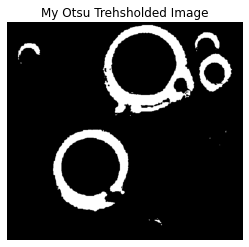

In [59]:
# theshold the image now
img_polymercell_otsu = np.where(img_polymercell > my_otsu_thres, 1, 0)
plt.figure()
plt.imshow(img_polymercell_otsu, cmap='gray')
plt.title("My Otsu Trehsholded Image")
plt.axis('off');

Using skimage's built-in Otsu

Skimage's built-in routine found threshold:  181


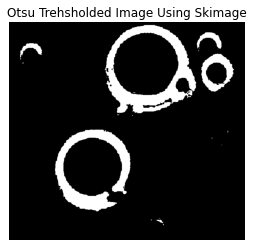

In [60]:
built_in_otsu = skimage.filters.threshold_otsu(img_polymercell, nbins=256)
print("Skimage's built-in routine found threshold: ", built_in_otsu)

# threshold the image
img_polymer_skimage_otsu = np.where(img_polymercell > built_in_otsu, 1, 0)

# display the image
plt.figure()
plt.imshow(img_polymer_skimage_otsu, cmap='gray')
plt.title("Otsu Trehsholded Image Using Skimage")
plt.axis('off');

Note that both algorithms yield the same results.

Let's explore the algorithm on an image corrupted by noise. As mentioned previously, noise can sometimes prevent a
thresholding algorithm from being useful. In order to combat that, we can smooth our image prior to thresholding.

The septagon image shown below has been corrupted by Guassian noise with 0 mean and standard deviation of 50 intensity
values.

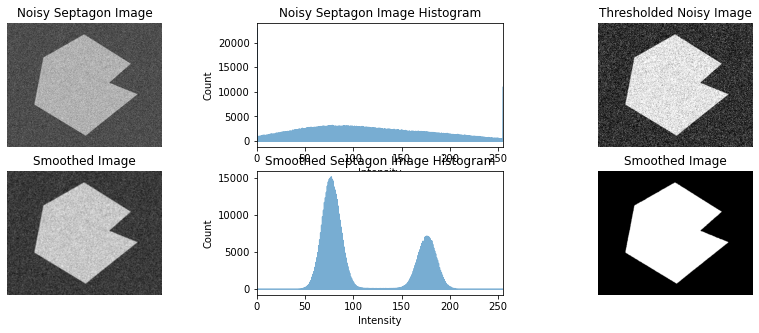

In [65]:
# load noisy septagon image
img_noisy_sep = io.imread('./images/septagon_gaussian_noise_mean_0_std_50_added.tif')

# compute the histogram
bins_to_use = np.arange(0, 256, 0.2)
sep_orig_hist, sep_orig_bins = np.histogram(img_noisy_sep, bins=bins_to_use)

# Apply Otsu's thresholding algorithm
sep_noisy_thresh, _ = my_otsu_threshold(img_noisy_sep)
img_noisy_sep_otsu = np.where(img_noisy_sep > sep_noisy_thresh, 1, 0)

# Smooth the image with an averaging kernel of size 5 x 5
avg_krnl = (1 / 25) * np.ones((5, 5))
img_sep_smoothed = convolve(img_noisy_sep, avg_krnl)

# compute the new histogram
sep_smooth_hist, sep_smooth_bins = np.histogram(img_sep_smoothed, bins=bins_to_use)

# Apply Otsu's thresholding algorithm to the smoothed image
sep_smooth_thresh, _ = my_otsu_threshold(img_sep_smoothed)
img_sep_smooth_otsu = np.where(img_sep_smoothed > sep_smooth_thresh, 1, 0)

# display the results so far
fig_sep_2, ax_sep_2 = plt.subplots(2, 3, figsize=(15, 5))
ax_sep_2 = ax_sep_2.ravel()

ax_sep_2[0].imshow(img_noisy_sep, cmap='gray')
ax_sep_2[0].set_title("Noisy Septagon Image")
ax_sep_2[0].axis('off')

ax_sep_2[1].plot(sep_orig_bins[:-1], sep_orig_hist, alpha=0.6, label='Noisy Image')
ax_sep_2[1].set_xlim([0, 255])
ax_sep_2[1].set_title("Noisy Septagon Image Histogram")
ax_sep_2[1].set_xlabel("Intensity")
ax_sep_2[1].set_ylabel("Count")

ax_sep_2[2].imshow(img_noisy_sep_otsu, cmap='gray')
ax_sep_2[2].set_title("Thresholded Noisy Image")
ax_sep_2[2].axis('off')

ax_sep_2[3].imshow(img_sep_smoothed, cmap='gray')
ax_sep_2[3].set_title("Smoothed Image")
ax_sep_2[3].axis('off')

ax_sep_2[4].plot(sep_smooth_bins[:-1], sep_smooth_hist, alpha=0.6, label='Smoothed Image')
ax_sep_2[4].set_xlim([0, 255])
ax_sep_2[4].set_title("Smoothed Septagon Image Histogram")
ax_sep_2[4].set_xlabel("Intensity")
ax_sep_2[4].set_ylabel("Count")

ax_sep_2[5].imshow(img_sep_smooth_otsu, cmap='gray')
ax_sep_2[5].set_title("Smoothed Image")
ax_sep_2[5].axis('off');

Note that we were able to succesfully threshold the image after smoothing. From the smooth's image histogram shown above,
we see that our main advantage was getting a bimodal histogram distribution.

In [67]:
print(np.max(sep_orig_hist))
print(np.argmax(sep_orig_hist))

22843
0
